## Running a genetic programming algorithm

In [1]:
import numpy as np
from thefittest.optimizers import SelfCGP
from thefittest.tools import donothing
from thefittest.base import FunctionalNode
from thefittest.base import TerminalNode
from thefittest.base import EphemeralNode
from thefittest.base import UniversalSet
from thefittest.tools.operators import Mul
from thefittest.tools.operators import Add
from thefittest.tools.operators import Inv
from thefittest.tools.operators import Pow2
from thefittest.tools.operators import Neg
from thefittest.tools.operators import Cos
from thefittest.tools.operators import Sin
from thefittest.tools.metrics import coefficient_determination
from thefittest.benchmarks.symbolicregression17 import problems_dict


def generator1():
    return np.round(np.random.uniform(0, 10), 4)


def generator2():
    return np.random.randint(0, 10)


def problem(x):
    return 3*x[:, 0]**2 + 2*x[:, 0] + 5


function = problems_dict['F1']['function']
left_border = problems_dict['F1']['bounds'][0]
right_border = problems_dict['F1']['bounds'][1]
sample_size = 300
n_dimension = problems_dict['F1']['n_vars']

number_of_iterations = 300
population_size = 500

X = np.array([np.linspace(left_border, right_border, sample_size)
              for _ in range(n_dimension)]).T
y = function(X)


functional_set = [FunctionalNode(Add()),
                  FunctionalNode(Mul()),
                  FunctionalNode(Neg()),
                  FunctionalNode(Inv()),
                  FunctionalNode(Pow2()),
                  FunctionalNode(Cos()),
                  FunctionalNode(Sin())]


terminal_set = [TerminalNode(X[:, i], f'x{i}') for i in range(n_dimension)]
terminal_set.extend([EphemeralNode(generator1), EphemeralNode(generator2)])
uniset = UniversalSet(functional_set, terminal_set)


def fitness_function(trees):
    fitness = []
    for tree in trees:
        y_pred = tree()*np.ones(len(y))
        fitness.append(coefficient_determination(y, y_pred))
    return np.array(fitness)


model = SelfCGP(fitness_function=fitness_function,
                genotype_to_phenotype=donothing,
                uniset=uniset,
                pop_size=population_size,
                iters=number_of_iterations,
                show_progress_each=10,
                minimization=False,
                keep_history=True)

model.fit()

fittest = model.get_fittest()
genotype, phenotype, fitness = fittest.get()
print('The fittest individ:', phenotype)
print('with fitness', fitness)

stats = model.get_stats()

y_pred = phenotype()*np.ones_like(y)


0 iteration with fitness = 0.020061875406827134
10 iteration with fitness = 0.20636387430036995
20 iteration with fitness = 0.2747078003944359
30 iteration with fitness = 0.463761440993959
40 iteration with fitness = 0.6256685710068381
50 iteration with fitness = 0.7626044574197077
60 iteration with fitness = 0.8910823867525052
70 iteration with fitness = 0.9202433645113837
80 iteration with fitness = 0.9377394234815132
90 iteration with fitness = 0.9402960358386486
100 iteration with fitness = 0.940380742796602
110 iteration with fitness = 0.940380742796602
120 iteration with fitness = 0.9405454576676935
130 iteration with fitness = 0.9412677146317584
140 iteration with fitness = 0.9412677146317584
150 iteration with fitness = 0.9414258293632751
160 iteration with fitness = 0.9414258293632751
170 iteration with fitness = 0.9414258293632751
180 iteration with fitness = 0.9414258293632751
190 iteration with fitness = 0.9414258293632751
200 iteration with fitness = 0.9428920997546139
210

## matplotlib and networkx visualization

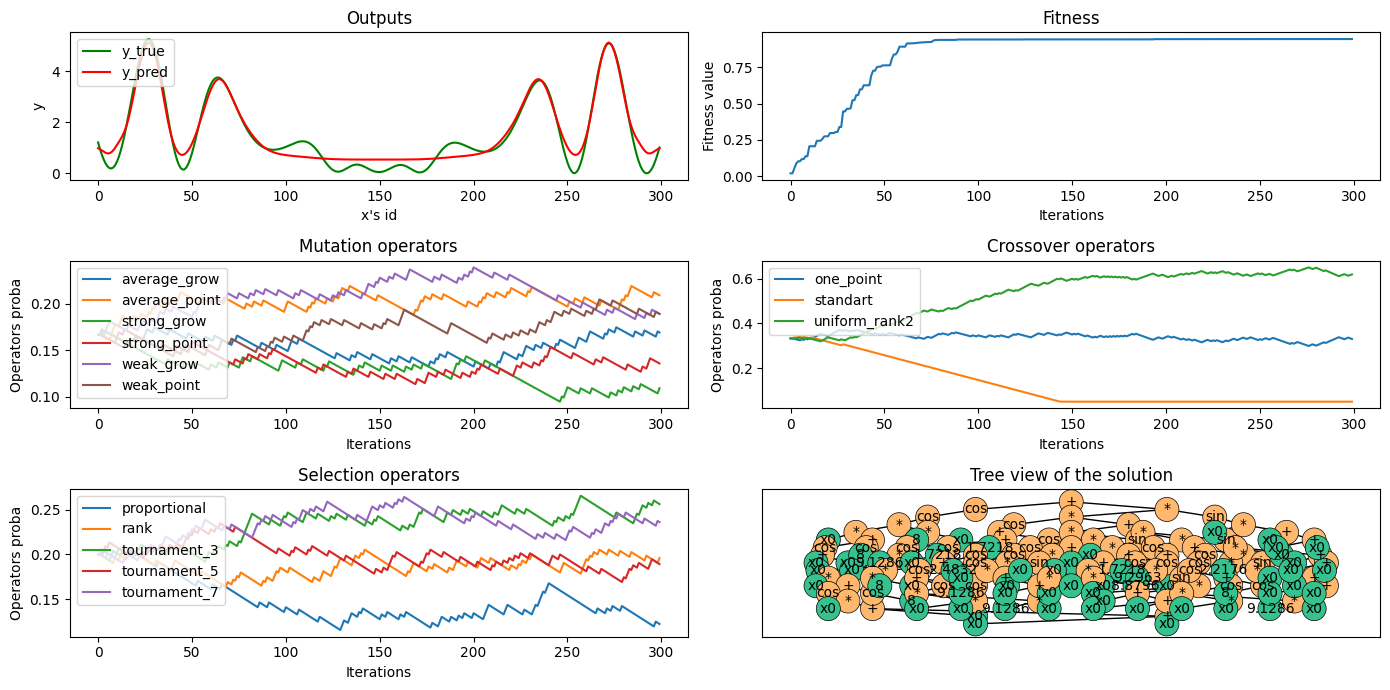

In [2]:
import networkx as nx
import matplotlib.pyplot as plt


def print_tree(some_tree, ax):
    graph = some_tree.get_graph(False)
    g = nx.Graph()
    g.add_nodes_from(graph['nodes'])
    g.add_edges_from(graph['edges'])

    nx.draw_networkx_nodes(g, graph['pos'], node_color=graph['colors'],
                           edgecolors='black', linewidths=0.5, ax=ax)
    nx.draw_networkx_edges(g, graph['pos'], ax=ax)
    nx.draw_networkx_labels(
        g, graph['pos'], graph['labels'], font_size=10, ax=ax)


s_proba = {}
c_proba = {}
m_proba = {}
for proba, proba_name in zip([s_proba, c_proba, m_proba],
                             ['s_proba', 'c_proba', 'm_proba']):
    for m_proba_i in stats[proba_name]:
        for key, value in m_proba_i.items():
            if key not in proba.keys():
                proba[key] = [value]
            else:
                proba[key].append(value)
fig, ax = plt.subplots(figsize=(14, 7), ncols=2, nrows=3)

ax[0][0].plot(range(len(X)), y, label='y_true', color='green')
ax[0][0].plot(range(len(X)), y_pred, label='y_pred', color='red')
ax[0][0].set_title('Outputs')
ax[0][0].set_ylabel('y')
ax[0][0].set_xlabel("x's id")
ax[0][0].legend(loc="upper left")

ax[0][1].plot(range(number_of_iterations), stats['fitness_max'])
ax[0][1].set_title('Fitness')
ax[0][1].set_ylabel('Fitness value')
ax[0][1].set_xlabel("Iterations")

for key, value in m_proba.items():
    ax[1][0].plot(range(number_of_iterations), value, label=key)
ax[1][0].legend(loc="upper left")
ax[1][0].set_title('Mutation operators')
ax[1][0].set_ylabel('Operators proba')
ax[1][0].set_xlabel("Iterations")

for key, value in c_proba.items():
    ax[1][1].plot(range(number_of_iterations), value, label=key)
ax[1][1].legend(loc="upper left")
ax[1][1].set_title('Crossover operators')
ax[1][1].set_ylabel('Operators proba')
ax[1][1].set_xlabel("Iterations")

for key, value in s_proba.items():
    ax[2][0].plot(range(number_of_iterations), value, label=key)
ax[2][0].legend(loc="upper left")
ax[2][0].set_title('Selection operators')
ax[2][0].set_ylabel('Operators proba')
ax[2][0].set_xlabel("Iterations")

print_tree(phenotype, ax[2][1])
ax[2][1].set_title('Tree view of the solution')

plt.tight_layout()
plt.show()
